In [94]:
import sys
import os
import random
sys.path.insert(0, "%s/hgcalEnv/lib/python3.6/site-packages/"%os.getcwd())

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

from matplotlib.collections import PatchCollection
import matplotlib

savePlots = False

In [2]:
#list of number of link that are assigned
linkSummary = pd.read_csv('geomInfo/ModuleLinkSummary.csv')

# six cassettes are put together to form one layer. Currently, we look at only 0th cassete of a few layers (5,7,9)
linkSummary = linkSummary[(linkSummary.Cassette==0) & (linkSummary.Layer>=5) & (linkSummary.Layer<=9)]

# The (ModU, modV) is the (U, V) coordinate of a module (=wafer=econ) within a layer
linkSummary.set_index(['Layer','ModU','ModV'],inplace=True)

In [3]:
#load data from csv files.  This is used to extract average data sizes
#daq_Data = pd.concat([pd.read_csv(f'Data/ttbar_copy_new.csv') for i in range(16)])
daq_Data = pd.read_csv('dataZS_merged.csv')
'''
The daq_Data consist of the entries after applying ZS corresponding to different cells 
(a layer has many wafers, a wafer has many cells). The description about the each of columns
(c1): It is the index of df
(c2 = entry): those events which passed the ZS
(c3 = layer): layer number (from 5 to 9)
(c4 = waferu): U coordinate of the wafer
(c5 = waferv): V coordinate of the wafer

(c6 = HDM): high density module: One of the 8-inch wafers/modules with 432 cells 
(compared to the LDM, or low-density module, which has 192 cells)
the type 0 are 120 micron thick and HDM and closest to beam pipe,
type 1 is 200 microns thick LDM modules, and a little further out
type 2 are 300 micron LDM modules, and furthest from beam pipe in eta
If HDM is True then it correspond to type 0 else 1 or 2

(c7 = occ): Occupancy: Each wafer has 3-6 eLink, each eLink has up to 37 channels, 
we’ve applied the zero suppression, so any channel below the threshold is removed, 
so the count is just counting how many cells on a given eLink on a given wafer pass the ZS

(c8 = eRxPacket_Words): It is the size of the packet in terms of number of words (1 word is of 32 bit).
It is calculated as int(Bits/32+1) + 2, where Bits = 16  + 8* (charge_BX1 + toa_BX2)

(c9  = NonEmptyLinks): We have total 6 (12) eLinks for HDM(LDM). 

(c10 = EmptyLinks): The rest eLinks

(c11 = TotalWords): evt_headerWords (=2) + eRxPacket_Words + EmptyLinks + evt_trailerWords (=2)

''' 
#daq_Data
#get list of wedges, and assign x and y positions for drawing maps
wedges = daq_Data.groupby(['layer','waferu','waferv']).any()[['HDM']].reset_index()
wedges['y'] = wedges.waferv
wedges['x'] = 0
#QQQQ: why 2+v-2*u?
wedges.loc[:,'x'] = (2+wedges.y-2*wedges.waferu)
#QQQQ: why rescale y and x?
wedges.y *= 1.5
wedges.x *= -3**.5/2
wedges.set_index(['layer','waferu','waferv'],inplace=True)


In [4]:
#function to look through output logs of condor jobs to extract and accumulate the results across several runs
# if you just ran interactivel, need to just get the info on the overflows, max size, etc into a dataframe.

def getDF(inputDF, LogDir="log", LogName=None,Nstart=0,N=100):
    #QQQQ: Why mean?
    fullData = inputDF.groupby(['layer','waferu','waferv']).mean()
    
    #linkSummary has only 153 rows which means the last 10 rows will be assigned Nan. 
    #QQQQ: Why linkSummary has only 153 rows?
    fullData['eTx_assigned'] = linkSummary.ECOND_eTX
    
    #Replace Nan by 1
    fullData.eTx_assigned = fullData.eTx_assigned.fillna(1).astype(int)
    
    #The numpy.ceil() is a mathematical function that returns the ceil of the elements of array. 
    #The ceil of the scalar x is the smallest integer i, such that i >= x
    #QQQQ: why divide by 53.3333? One eTx can process 53.3333 Words of data?
    fullData['eTx_Mean'] = np.ceil((fullData.TotalWords/53.3333))
    fullData['eTx_15percent'] = np.ceil((fullData.TotalWords/53.3333)*1.15).astype(int)
    fullData['eTx_30percent'] = np.ceil((fullData.TotalWords/53.3333)*1.3).astype(int)
    fullData['eTx_15percent_actual'] = fullData['eTx_15percent']/(fullData.TotalWords/53.3333)
    fullData['eTx_30percent_actual'] = fullData['eTx_30percent']/(fullData.TotalWords/53.3333)
    '''
    Every condor output has information for 6 econs (they have different # eLinks)
    We collect information from ALL condor outputs for ALL econs in a 2D (163,6) array

    overflows: An econ with few number of eLink is overflown for a few thousands times in 
    few million BX which means for few billion BXs (many condor outputs) the overflows should be added

    maxSize: Among all condor outputs, it is the maximum buffer occupancy. Which means it is NOT additive

    L1As issued: How many times an L1A is issued for a given number of BXs. Which means it is additive

    '''
    if not LogName is None:
        data_overflow = []
        data_maxSize = []
        L1As_issued=0
        bHist = []
        #Get the 0th element of the list from 0th condor file
        fileName = f'condor_buffer/tmpSub/{LogDir}/{LogName}_{Nstart}.stdout'
        with open(fileName,'r') as _file:
            # we loop over all lines of the condor output and extract
            for line in _file:
                if 'overflows= ' in line:
                    #overflows= [...]
                    data_overflow.append(eval(line[10:]))
                if 'maxSize= ' in line:
                    #maxSize= [...]
                    data_maxSize.append(eval(line[8:]))
                if 'L1As issued' in line:
                    #749401 L1As issued
                    L1As_issued += int(line.split()[0])
                if 'sizeHist= ' in line:
                    bHist.append(eval(line[9:]))
        #2D array            
        data_overflow=np.array(data_overflow)
        data_maxSize=np.array(data_maxSize)
        buff_Hist = np.array(bHist)

        for i_file in range(Nstart+1,Nstart+N):
            fileName = f'condor_buffer/tmpSub/{LogDir}/{LogName}_{i_file}.stdout'
            bHist = []
            with open(fileName,'r') as _file:
                for line in _file:
                    if 'eTx' in line:
                        #1 eTx
                        i = int(line.split()[0])-1
                    if 'overflows= ' in line:
                        overflow=np.array(eval(line[10:]))
                        overflow[overflow<0] = 99999999
                        data_overflow[i] += overflow
                    if 'maxSize= ' in line:
                        maxSize=np.array(eval(line[8:]))
                        data_maxSize[i] = np.maximum(data_maxSize[i], maxSize)
                    if 'L1As issued' in line:
                        L1As_issued += int(line.split()[0])
                    if 'sizeHist= ' in line:
                        bHist.append(eval(line[9:]))
            buff_Hist += np.array(bHist)
        
        '''
        The idea is to check how many eLinks are needed for a given wafer in order to avoid overflow.
        For example, the wafer closer to beam axis need more eLinks and vice versa. In this way we can
        efficiantly allocate different number of eLinks to different wafers
        '''
        #transpose (163 col, 6 rows) to (6 cols, 163 rows)
        #In every row look at zero (True==0) and non-zero entries
        #Multiply the respective entry by array([1, 2, 3, 4, 5, 6])
        x = ((data_overflow.transpose()==0)*np.arange(1,7))

        #change all zero entries to 99 (we can choose any large value)
        x[x==0]=99
        
        #for every row, get the minimum value (out of 6 econs, pick the one which has minimum eLink)
        minLinks = x.min(axis=1)
        fullData['min_eTx'] = minLinks
        nLinks = minLinks
        #print(data_overflow.transpose())
        
        #Get the maximum size of the buffer of the corresponding econ with minLinks
        maxSize = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
        fullData['maxSize'] = maxSize    

        
        nLinks = fullData.eTx_Mean.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][int(nLinks[i])-1])
            overflows.append(data_overflow.transpose()[i][int(nLinks[i])-1])
        fullData['maxSize_Mean'] = maxSize
        fullData['overflows_Mean'] = overflows
        
        
        nLinks = fullData.eTx_assigned.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
            overflows.append(data_overflow.transpose()[i][nLinks[i]-1])
        fullData['maxSize_assigned'] = maxSize
        fullData['overflows_assigned'] = overflows
        
        #15% overhead
        nLinks = fullData.eTx_15percent.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
            overflows.append(data_overflow.transpose()[i][nLinks[i]-1])
        fullData['maxSize_15percent']   = maxSize
        fullData['overflows_15percent'] = overflows
        
        #30% overhead
        nLinks = fullData.eTx_30percent.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
            overflows.append(data_overflow.transpose()[i][nLinks[i]-1])
        fullData['maxSize_30percent'] = maxSize
        fullData['overflows_30percent'] = overflows
        
        #print("fullData = ", fullData)
        #print("L1As_issued = ", L1As_issued)
        #print("data_overflow = ", data_overflow)
        #print("data_maxSize = ", data_maxSize)
    #return fullData, L1As_issued, data_overflow, data_maxSize, buff_Hist
    #print("buff_Hist", buff_Hist)
    return fullData, L1As_issued, buff_Hist, data_overflow, data_maxSize

In [95]:
def plotBuffHist(buffHist):
    colList = ["c", "b", "g", "r","m","y"]
    xArray = []
    for i in range(1536*2):
        xArray.append(i)
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    count = 1
    plt.subplots(figsize=(15, 10))
    #for h in range(len(buffHist)):
    for h in range(5):
        #print(count)
        plt.subplot(3, 5, count)
        for eTx in range(len(buffHist)):
            #plt.plot( xArray, buffHist[eTx][h], label="eTx=%i"%(eTx+1))
            plt.hist(xArray, bins=50, weights=buffHist[eTx][h], edgecolor=colList[eTx], label="eTx=%i"%(eTx+1), histtype='step', linewidth=2)
            plt.title("wafer=%s"%str(wedges.index[h]))
            #plt.xlabel("Buffer size (32-bit words)", size=14)
            #plt.xlabel("Buffer size", size=14)
            plt.legend(loc='upper center')
            plt.yscale('log')
        count+=1
    if savePlots:
        plotDir = "plots/BufferHist"
        os.system("mkdir -p %s"%plotDir)
        plt.savefig("%s/%s.pdf"%(plotDir, "buffHist"), bbox_inches='tight')
        plt.savefig("%s/%s.png"%(plotDir, "buffHist"), bbox_inches='tight', dpi=300)
    plt.show()

def plotSize(sizeList, linkList, buffHist, plotTit, m):
    xArray = []
    for i in range(1536*2):
        xArray.append(i)
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    plt.subplots(figsize=(25, 10))
    #indices of maximum buffer size
    #Return the index of original list after sorting it
    index5 = sorted(range(len(m[0:53])), key=lambda k: m[0:53][k])
    index7 = sorted(range(len(m[53:108])), key=lambda k: m[53:108][k])
    index9 = sorted(range(len(m[108:163])), key=lambda k: m[108:163][k])
    
    layers = {}
    layers["layer5"] = [index5[-1], index5[-2], index5[0]]
    layers["layer7"] = [53+index7[-1], 53+index7[-2], 53+index7[0]]
    layers["layer9"] = [108+index9[-1], 108+index9[-2], 108+index9[0]]
    count = 1
    yMin  = 1
    for layer in layers.keys():
        plt.subplot(3, 5, count)
        for wafer in layers[layer]:
            hist = buffHist[int(linkList[wafer])-1][wafer]
            lab = "ℓ, wu, wv = %s; eTx = %s, max= %s"%(wedges.index[wafer], int(linkList[wafer]), sizeList[wafer])
            plt.hist(xArray, bins=50, weights=hist, label=lab, histtype='step', linewidth=3)
            plt.xlabel("Buffer occupancy (32-bit words)", size=14)
            plt.ylabel("BX", size=14)
            plt.ylim(yMin, 10e12)
            plt.legend(loc='upper center')
            plt.yscale('log')
        count+=1
        plt.title(plotTit)
        plt.axvline(x=1536, color="r", linestyle='--')
        plt.axvline(x=3072, color="r", linestyle='--')
        plt.text(1536+50, 10e4*yMin, "128-word depth", rotation=90, verticalalignment='center')
        plt.text(3072+50, 10e4*yMin, "256-word depth", rotation=90, verticalalignment='center')
    if savePlots:
        plotDir = "plots/BufferOcc"
        os.system("mkdir -p %s"%plotDir)
        plt.savefig("%s/%s.pdf"%(plotDir, plotTit), bbox_inches='tight')
        plt.savefig("%s/%s.png"%(plotDir, plotTit), bbox_inches='tight', dpi=300)
    plt.show()
    
def plotMaxSize(xList, yList, xTit, yTit, plotTit, drawLine=False): 
    ETx = np.array(xList)
    l1_ETx = ETx[0:53]
    l2_ETx = ETx[53:53+55]
    l3_ETx = ETx[53+55:53+55+55]
    l1_overflow = []
    l2_overflow = []
    l3_overflow = []
    for i in np.arange(len(l1_ETx)):
        eTx = int(l1_ETx[i])
        l1_overflow.append(yList.transpose()[i][eTx-1])

    for i in np.arange(len(l2_ETx)):
        eTx = int(l2_ETx[i])
        l2_overflow.append(yList.transpose()[i+53][eTx-1])

    for i in np.arange(len(l3_ETx)):
        eTx = int(l3_ETx[i])
        l3_overflow.append(yList.transpose()[i+53+55][eTx-1])
    plt.figure(figsize=(6,4))
    plt.hist(l1_overflow, bins=70,  label="ℓ = 5 (53 wafers)     ", histtype='step', linewidth=3, edgecolor='r')
    plt.hist(l2_overflow, bins=70,  label="ℓ = 7 (55 wafers)     ", histtype='step', linewidth=3, edgecolor='g')
    plt.hist(l3_overflow, bins=70,  label="ℓ = 9 (55 wafers)     ", histtype='step', linewidth=3, edgecolor='b')
    plt.xlabel(xTit, size=14)
    plt.ylabel(yTit, size=14)
    plt.ylim(0.1, 60)
    plt.title(plotTit)
    plt.legend(loc="upper right", frameon=False)
    plt.yscale('log')
    if drawLine:
        plt.axvline(x=1536, color="r", linestyle='--')
        plt.axvline(x=3072, color="r", linestyle='--')
        plt.text(1536+50, 5, "128-word depth", rotation=90, verticalalignment='center')
        plt.text(3072+50, 5, "256-word depth", rotation=90, verticalalignment='center')
    if savePlots:
        plotDir = "plots/MaxBufferOcc"
        os.system("mkdir -p %s"%plotDir)
        plt.savefig("%s/%s.pdf"%(plotDir, plotTit), bbox_inches='tight')
        plt.savefig("%s/%s.png"%(plotDir, plotTit), bbox_inches='tight', dpi=300)
    plt.show()
        

def plotTotalWords(sizeList):   
    branchList = ['entry','layer','waferu','waferv','HDM','TotalWords', "TotalWords_NZS"]
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    plt.subplots(figsize=(15, 10))
    group = daq_Data.reset_index().groupby(['layer', 'waferu','waferv', 'HDM'])
    histDF = group['TotalWords'].apply(list).reset_index()
    histDF2 = group['TotalWords_NZS'].apply(list).reset_index()
    count = 1
    #Return the index of original list after sorting it
    index5 = sorted(range(len(sizeList[0:53])), key=lambda k: sizeList[0:53][k])
    index7 = sorted(range(len(sizeList[53:108])), key=lambda k: sizeList[53:108][k])
    index9 = sorted(range(len(sizeList[108:163])), key=lambda k: sizeList[108:163][k])
    
    layers = {}
    layers["layer5"] = [index5[-1], index5[-2], index5[0]]
    layers["layer7"] = [53+index7[-1], 53+index7[-2], 53+index7[0]]
    layers["layer9"] = [108+index9[-1], 108+index9[-2], 108+index9[0]]
    for layer in layers.keys():
        for wafer in layers[layer]:
            #print(count)
            #luv = random.choice(wedges.index)
            luv = wedges.index[wafer]
            print(luv)
            plt.subplot(3, 5, count)
            sel = (histDF.layer==luv[0]) & (histDF.waferu==luv[1]) & (histDF.waferv==luv[2])
            histList = histDF.loc[sel, 'TotalWords'].to_list()
            histList_NZS = histDF2.loc[sel, 'TotalWords_NZS'].to_list()
            #print(histList)
            #print(histList_NZS)
            plt.hist(histList, label="ZS", histtype='step', linewidth=2)
            plt.hist(histList_NZS, label="NZS", histtype='step', linewidth=2)
            plt.title("(layer, wu, wv)=%s"%str(luv))
            plt.xlabel("Total 32-bit words", size=14)
            plt.ylabel("Events", size=14)
            plt.legend(loc='upper center')
            #plt.yscale('log')
            count+=1
    if savePlots:
        plotDir = "plots/TotalWords"
        os.system("mkdir -p %s"%plotDir)
        plt.savefig("%s/%s.pdf"%(plotDir, "totalWords"), bbox_inches='tight')
        plt.savefig("%s/%s.png"%(plotDir, "totalWords"), bbox_inches='tight', dpi=300)
    plt.show()
    
def plotOverFlow(OF):
    plt.figure(figsize=(6,4))
    plt.hist(OF[0], bins=70,  label="1 eTx", fill=False, linewidth=3, edgecolor='c')
    plt.hist(OF[1], bins=70,  label="2 eTx", fill=False, linewidth=3, edgecolor='b')
    plt.hist(OF[2], bins=70,  label="3 eTx", fill=False, linewidth=3, edgecolor='g')
    plt.hist(OF[3], bins=70,  label="4 eTx", fill=False, linewidth=3, edgecolor='r')
    plt.hist(OF[4], bins=70,  label="5 eTx", fill=False, linewidth=3, edgecolor='m')
    plt.hist(OF[5], bins=70,  label="6 eTx", fill=False, linewidth=3, edgecolor='y')
    plt.xlabel("Overflows", size=14)
    plt.ylabel("Number of Wafers", size=14)
    plt.yscale('log')
    plt.title("Overflows for different numbers of eTx")
    plt.legend(loc='upper right')

    
def plot2D(fullData):
    #dictionaly of the labels for different types of plots
    Labels ={'occ':{'Title':'Layer %i',
                    'colorLabel':'Average cell occupancy above ZS',
                    'nDec':1,
                    'zMax':260},
             'TotalWords':{'Title':'Layer %i',
                          'colorLabel':'Average data size (32b words) after L1A',
                          'nDec':1,
                          'zMax':200},
             'EmptyLinks':{'Title':'Layer %i',
                          'colorLabel':'Average # of empty eRx packets',
                          'nDec':1,
                          'zMax':6},
             'min_eTx':{'Title':'Layer %i',
                          'colorLabel':'Minimum number of eTx with 0 overflow',
                          'nDec':0,
                          'zMax':6},
             'maxSize':{'Title':'Layer %i',
                          'colorLabel':'MBO with 0 overflow',
                          'nDec':0,
                          'zMax':100},
             'eTx_Mean':{'Title':'Layer %i',
                          'colorLabel':'#eTx from mean',
                          'nDec':2,
                          'zMax':6},
             'eTx_15percent':{'Title':'Layer %i',
                          'colorLabel':'#eTx from mean + 15%',
                          'nDec':0,
                          'zMax':6},
             'eTx_15percent_actual':{'Title':'Layer %i',
                          'colorLabel':'actual overhead for #eTx from mean + 15%',
                          'nDec':0,
                          'zMax':6},        
             'eTx_30percent':{'Title':'Layer %i',
                          'colorLabel':'#eTx from mean + 30%',
                          'nDec':0,
                          'zMax':6},
             'eTx_30percent_actual':{'Title':'Layer %i',
                          'colorLabel':'actual overhead for #eTx from mean + 30%',
                          'nDec':0,
                          'zMax':6},             
             'eTx_assigned':{'Title':'Layer %i',
                          'colorLabel':'#eTx from HGCal baseline',
                          'nDec':0,
                          'zMax':6},
             'maxSize_Mean':{'Title':'Layer %i',
                          'colorLabel':'MBO for #eTx from mean',
                          'nDec':0,
                          'zMax':100},
             'maxSize_15percent':{'Title':'Layer %i',
                          'colorLabel':'MBO for #eTx from mean + 15%',
                          'nDec':0,
                          'zMax':100},
             'maxSize_30percent':{'Title':'Layer %i',
                          'colorLabel':'MBO for #eTx from mean + 30%',
                          'nDec':0,
                          'zMax':100},
             'maxSize_assigned':{'Title':'Layer %i',
                          'colorLabel':'MBO for #eTx from HGCal baseline',
                          'nDec':0,
                          'zMax':100},
             'overflows_Mean':{'Title':'Layer %i',
                          'colorLabel':'Overflows for #eTx from mean',
                          'nDec':0,
                          'zMax':40000},
             'overflows_15percent':{'Title':'Layer %i',
                          'colorLabel':'Overflows for #eTx from mean + 15%',
                          'nDec':0,
                          'zMax':40000},
             'overflows_30percent':{'Title':'Layer %i',
                          'colorLabel':'Overflows for #eTx from mean + 30%',
                          'nDec':0,
                          'zMax':40000},
             'overflows_assigned':{'Title':'Layer %i',
                          'colorLabel':'Overflows for #eTx from HGCal baseline',
                          'nDec':0,
                          'zMax':40000},
            }
    
    #for var in Labels:
    #for var in ["eTx_Mean", "eTx_30percent",  "eTx_assigned", "eTx_30percent_actual"]:
    for var in ["min_eTx", "eTx_assigned", "maxSize_assigned", "overflows_assigned", "eTx_Mean", "maxSize_Mean", "overflows_Mean", "eTx_30percent", "maxSize_30percent", "overflows_30percent", "eTx_30percent_actual","eTx_15percent", "maxSize_15percent", "overflows_15percent", "eTx_15percent_actual"]:    
        print(var)
        plt.subplots(figsize=(15, 5))
        count=1
        for layer in [5,7,9]:
            wedge = wedges.loc[layer]
            #fig, ax = plt.subplots()
            plt.subplot(1, 3, count)
            ax=plt.gca()
            patches = []
            for w in wedge.index:
                patches.append(mpatches.RegularPolygon((wedge.loc[w].x,wedge.loc[w].y),6, .95))
            extra = "ttbar"
            data = fullData.loc[layer,var].values.flatten()
            if 'maxSize' in var:
                data = data*100/3072
            waferCollection = PatchCollection(patches,cmap=matplotlib.cm.coolwarm)
            waferCollection.set_array(data)
            waferCollection.set_clim([0,Labels[var]['zMax']])
            ax.add_collection(waferCollection)
            plt.axis([0,16,-1,15])
            plt.rcParams["figure.autolayout"] = True
            # ax.set_xticklabels([])
            # ax.set_yticklabels([]);
            cbar = plt.colorbar(waferCollection)
            cbar.set_label(Labels[var]['colorLabel'],fontsize=14)

            wedge['data'] = data
            plt.title(Labels[var]['Title']%layer,fontsize=14)
            for x,y,d in wedge[['x','y','data']].values:
            #     s = data[i]
                text = f'%.{Labels[var]["nDec"]}f'%d
                if len(str(d))>4:
                    text = "{:.2e}".format(d)
                    text = "%s\ne%s"%(text.split("e")[0], text.split("e")[1])
                if "maxSize" in var:
                    per = round(d,1)
                    text = "%s\n%s"%(per, "%")
                if "actual" in var:
                    per = int((d-1.)*100)
                    text = "%s\n%s"%(per, "%")
                plt.text(x,y,text,fontsize=9,horizontalalignment='center',verticalalignment='center')         

            #fig.savefig(f'Plots/{var}_layer{layer}{extra}.png')
            count+=1
        if savePlots:
            plotDir = "plots/2DPlots"
            os.system("mkdir -p %s"%plotDir)
            plt.savefig("%s/%s.pdf"%(plotDir, var), bbox_inches='tight')
            plt.savefig("%s/%s.png"%(plotDir, var), bbox_inches='tight', dpi=300)
    plt.show()



In [6]:
fullData, L1As, buffHist, OF, MS = getDF(daq_Data, 'log_0', 'bufferSim__74754635', 0, 100)

In [7]:
fullData2, L1As2, buffHist2, OF2, MS2 = getDF(daq_Data, 'log_100', 'bufferSim__74754636', 0, 100)

In [8]:
#fullData3, L1As3, buffHist3, OF3, MS3 = getDF(daq_Data, 'log_1000', 'bufferSim__74754637', 0, 100)

In [96]:
def plotAll(fullData, L1As, buffHist, OF, MS):
    eTxMean = "#eTx from mean"
    eTx15p  = "#eTx from mean + 15%"
    eTx30p  = "#eTx from mean + 30%"
    eTxHGCal= "#eTx from HGCal baseline"
    yTit = "Number of Wafers"
    xTit = "Number of times buffer has Overflown"
    
    #plotMaxSize(fullData.eTx_Mean.tolist(), OF, xTit, yTit, eTxMean)
    #plotMaxSize(fullData.eTx_30percent.tolist(), OF, xTit, yTit, eTx30p)
    #plotMaxSize(fullData.eTx_assigned.tolist(), OF, xTit, yTit, eTxHGCal)

    yTit = "Number of Wafers"
    xTit = "Max buffer occupancy (32-bit words)"
    plotMaxSize(fullData.eTx_Mean.tolist(), MS, xTit, yTit, eTxMean, True)
    plotMaxSize(fullData.eTx_15percent.tolist(), MS, xTit, yTit, eTx15p, True)
    plotMaxSize(fullData.eTx_30percent.tolist(), MS, xTit, yTit, eTx30p, True)
    plotMaxSize(fullData.eTx_assigned.tolist(), MS, xTit, yTit, eTxHGCal, True)
    
    #To pick modules based on maxSize from 15% + mean
    #m = fullData.maxSize_15percent.values
    #plotSize(fullData.maxSize_Mean.values, fullData.eTx_Mean.values, buffHist, eTxMean, m)
    #plotSize(fullData.maxSize_15percent.values, fullData.eTx_15percent.values, buffHist, eTx15p, m)
    #plotSize(fullData.maxSize_assigned.values, fullData.eTx_assigned.values, buffHist, eTxHGCal, m)
    
    #To pick modules based on maxSize from 30% + mean
    m = fullData.maxSize_30percent.values
    plotSize(fullData.maxSize_Mean.values, fullData.eTx_Mean.values, buffHist, eTxMean, m)
    plotSize(fullData.maxSize_30percent.values, fullData.eTx_30percent.values, buffHist, eTx30p, m)
    plotSize(fullData.maxSize_assigned.values, fullData.eTx_assigned.values, buffHist, eTxHGCal, m)

    #plotBuffHist(buffHist)
    plot2D(fullData)
    plotTotalWords(m)
    

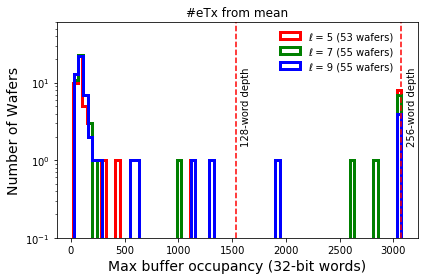

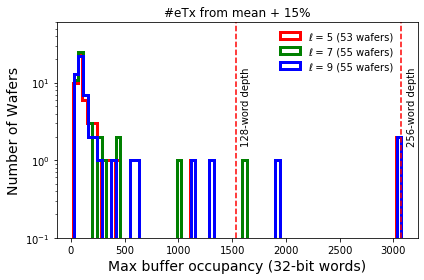

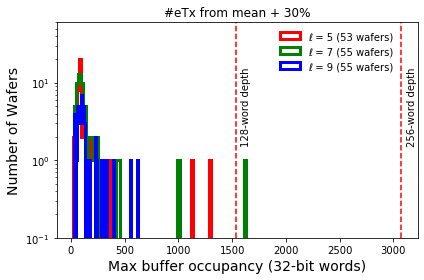

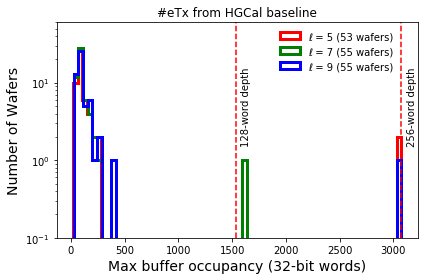

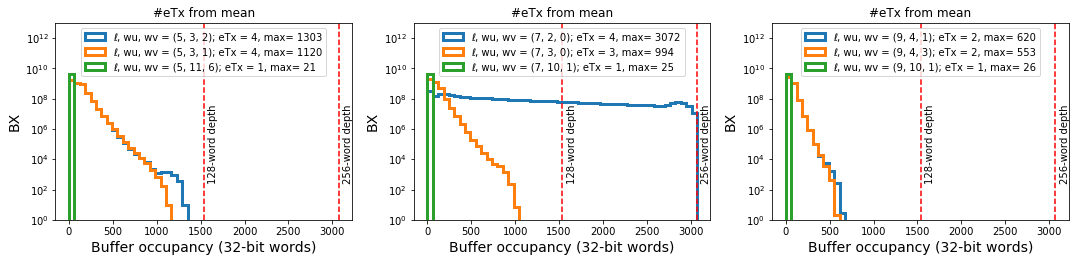

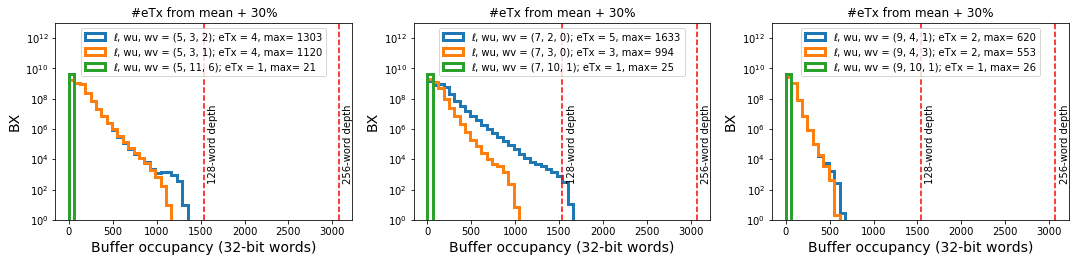

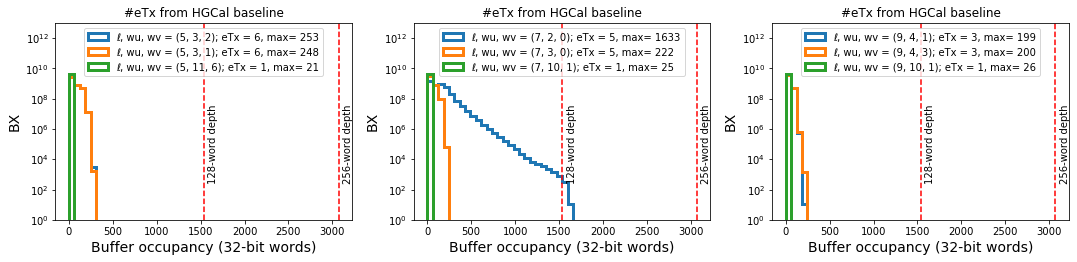

min_eTx


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


eTx_assigned
maxSize_assigned
overflows_assigned
eTx_Mean
maxSize_Mean
overflows_Mean
eTx_30percent
maxSize_30percent
overflows_30percent
eTx_30percent_actual
eTx_15percent
maxSize_15percent
overflows_15percent
eTx_15percent_actual


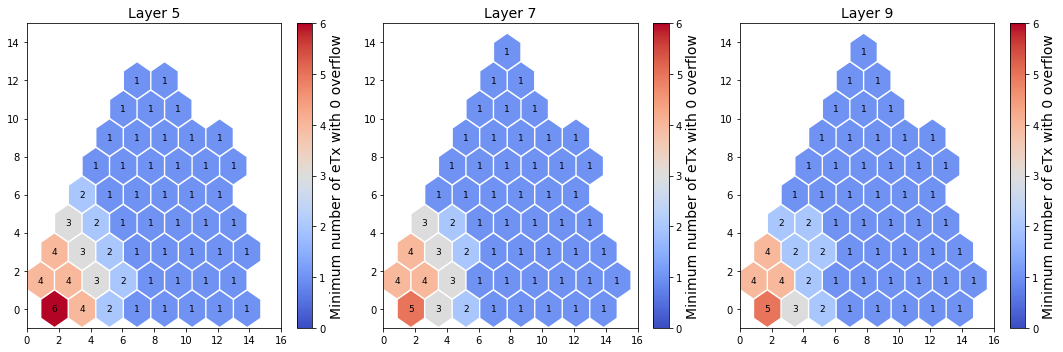

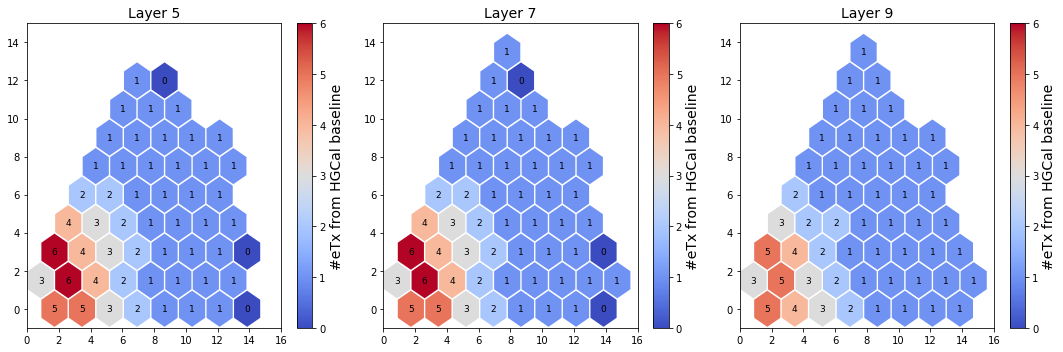

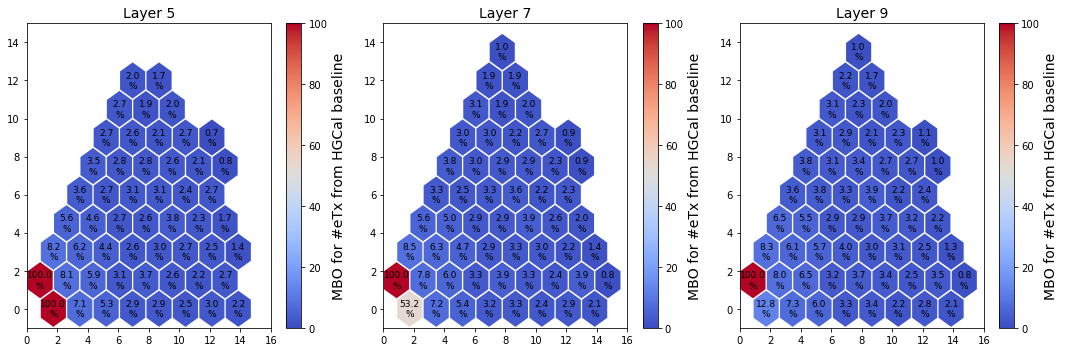

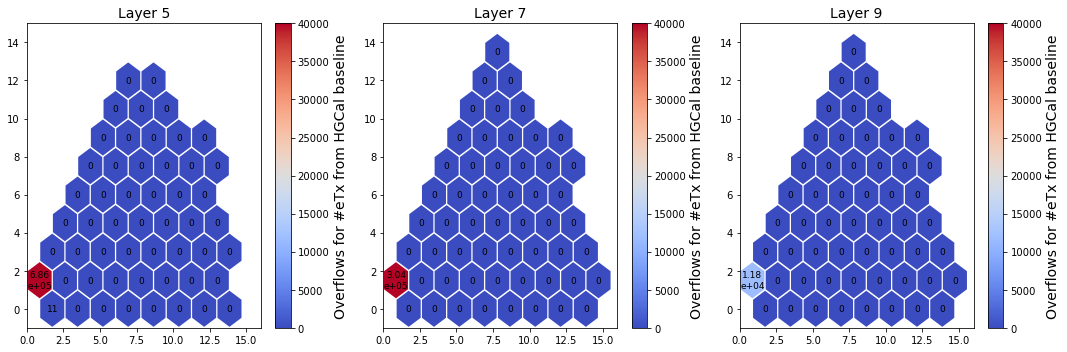

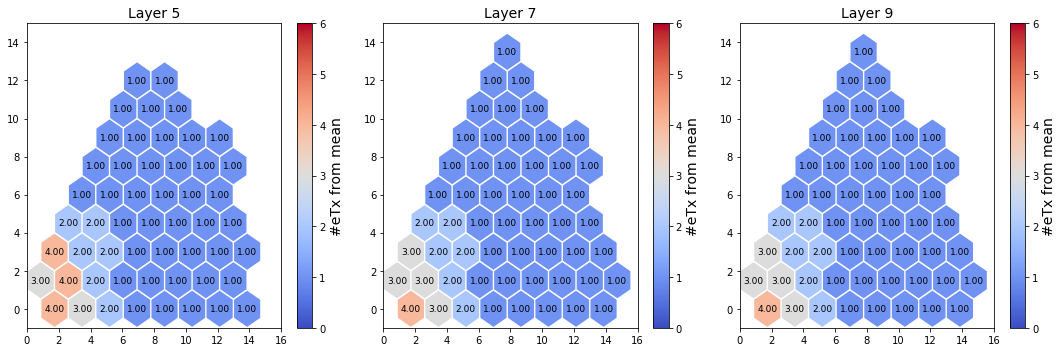

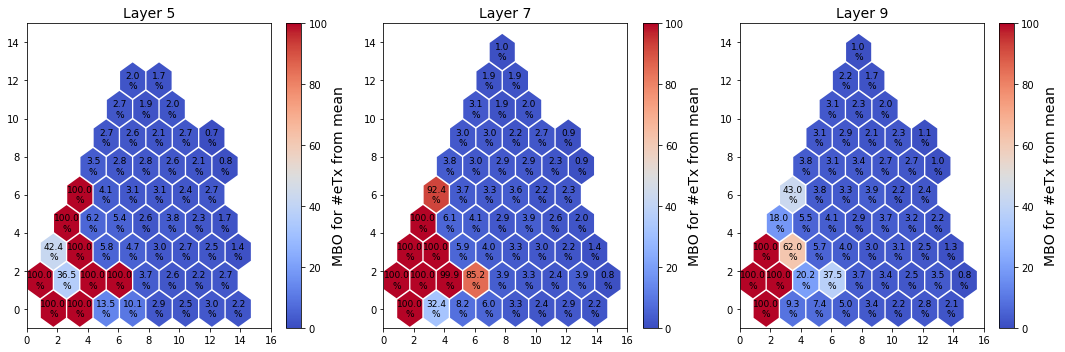

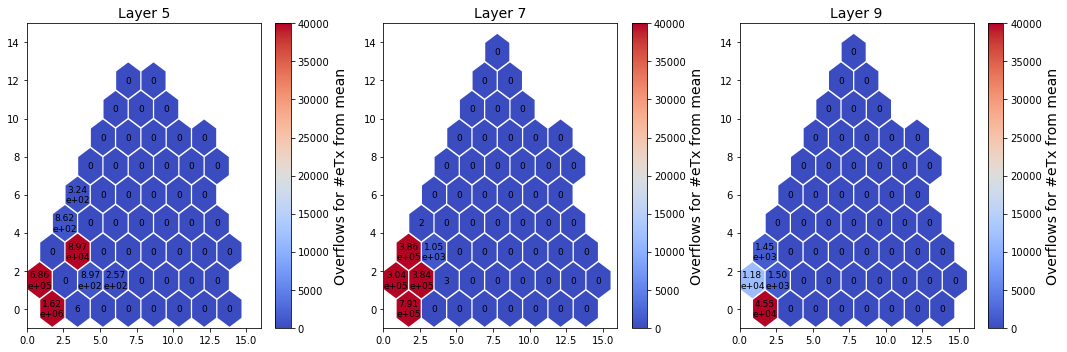

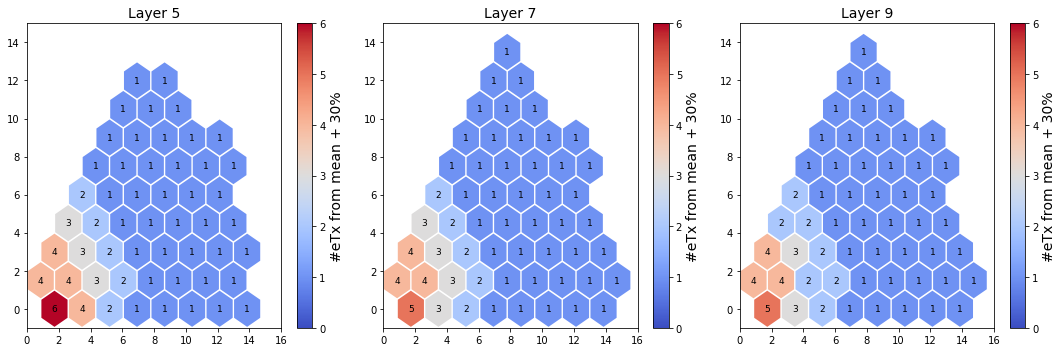

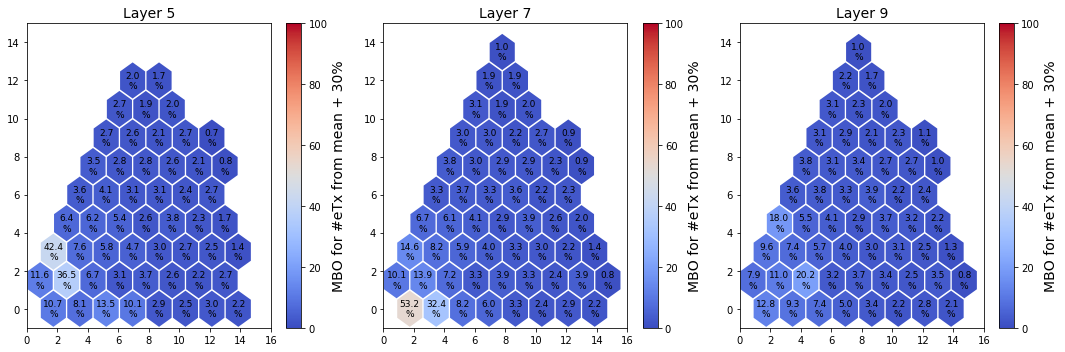

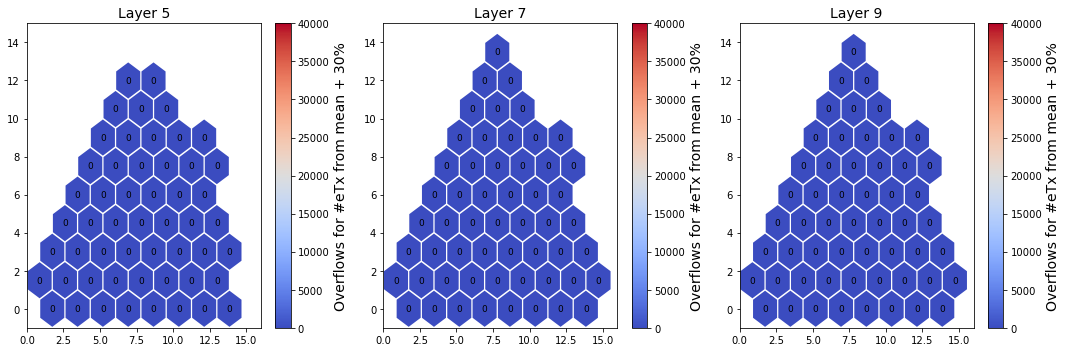

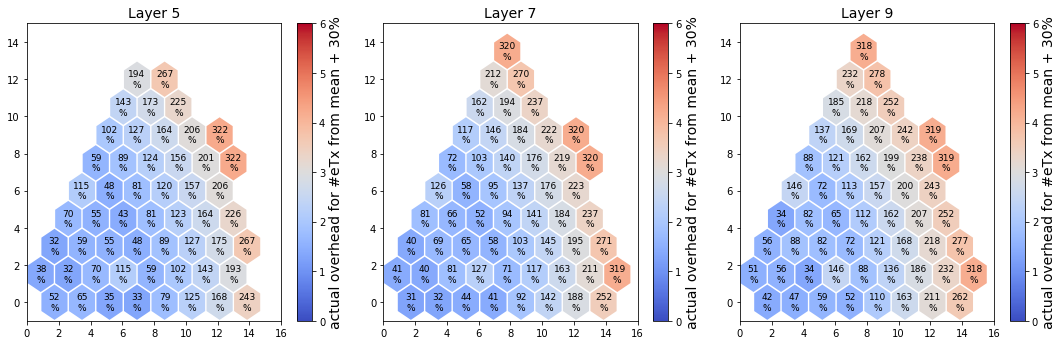

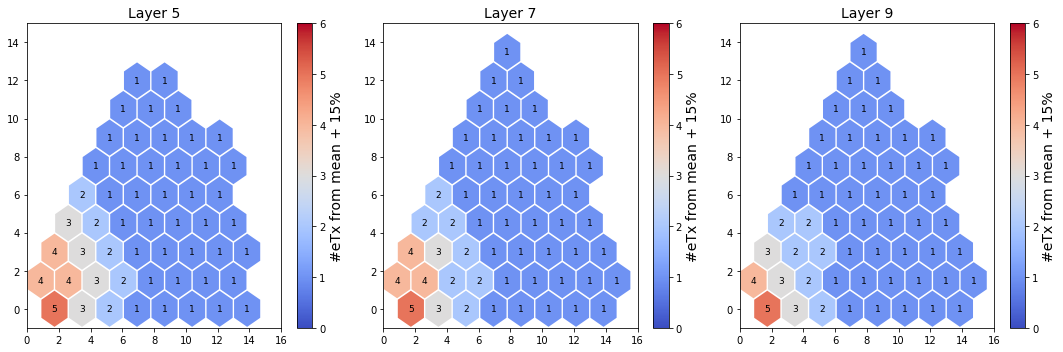

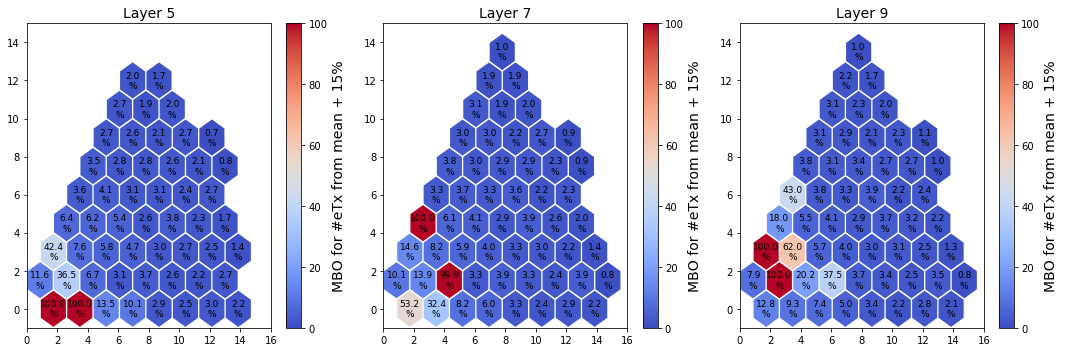

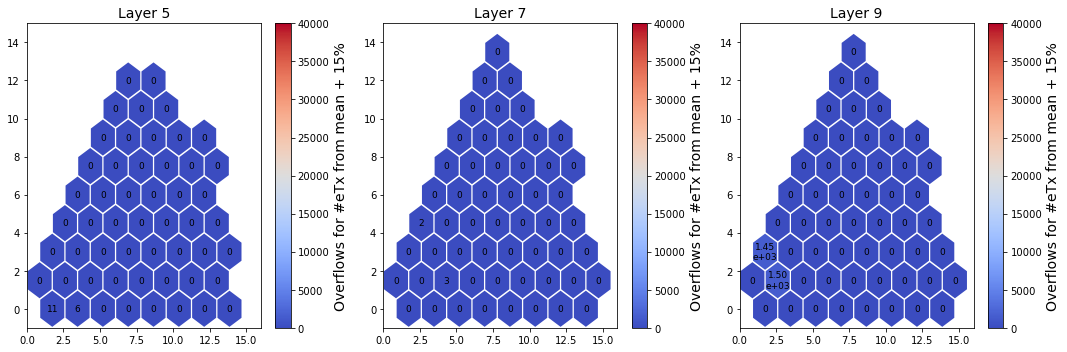

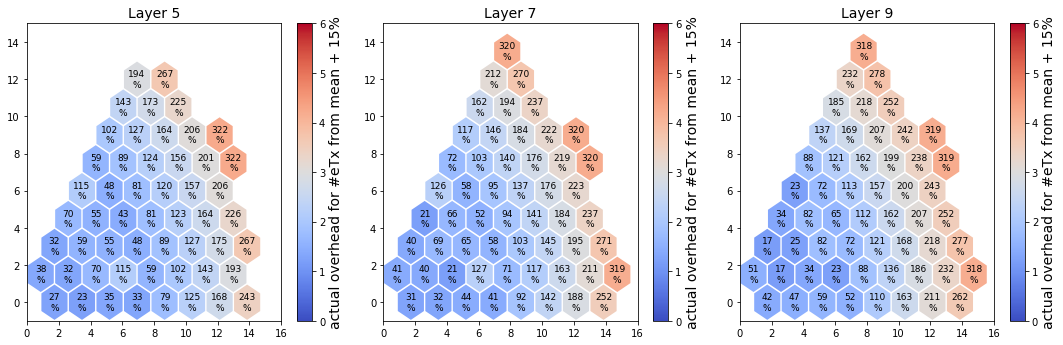

(5, 3, 2)
(5, 3, 1)
(5, 11, 6)
(7, 2, 0)
(7, 3, 0)
(7, 10, 1)
(9, 4, 1)
(9, 4, 3)
(9, 10, 1)


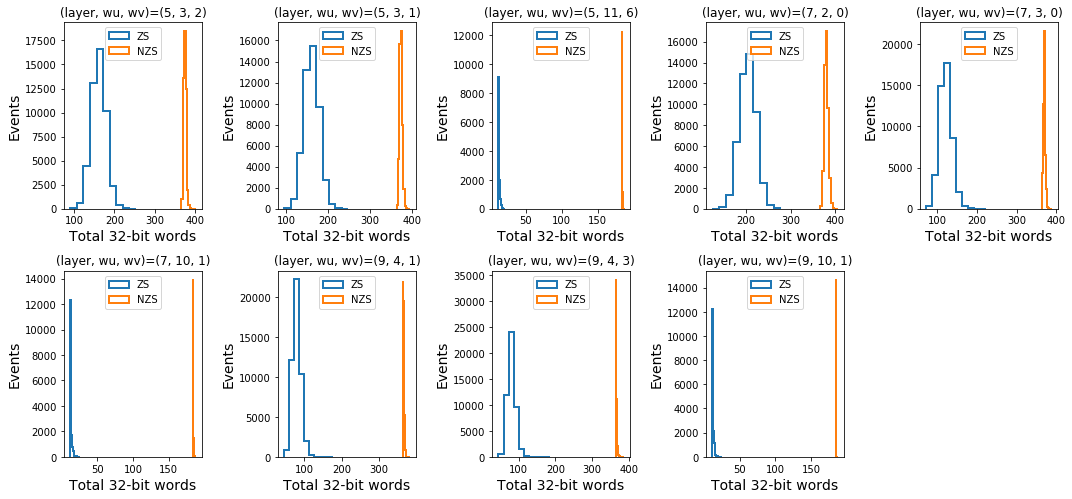

In [97]:
plotAll(fullData, L1As, buffHist, OF, MS)

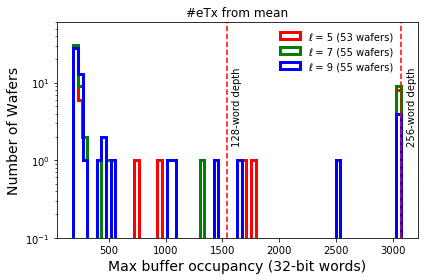

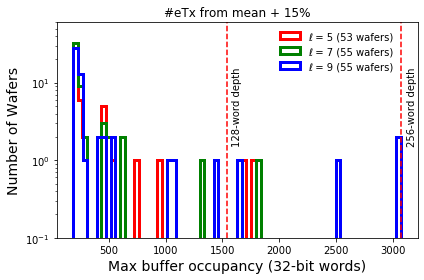

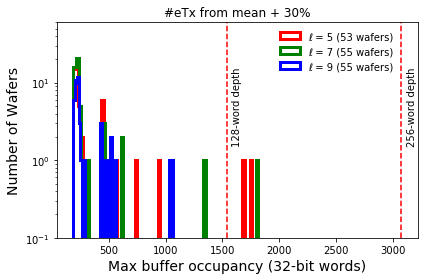

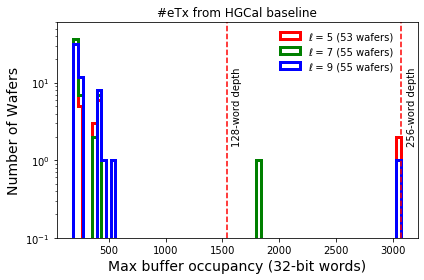

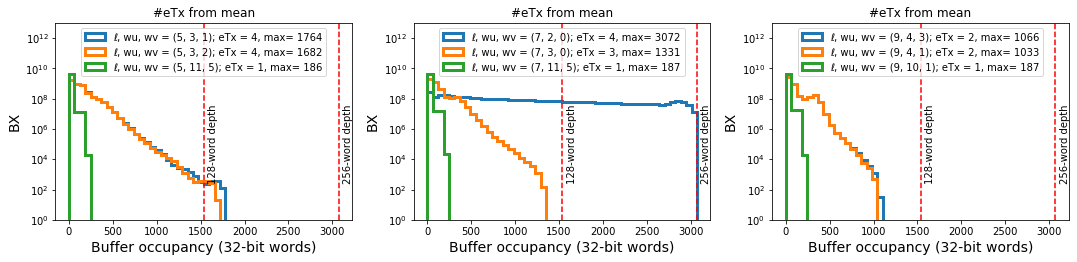

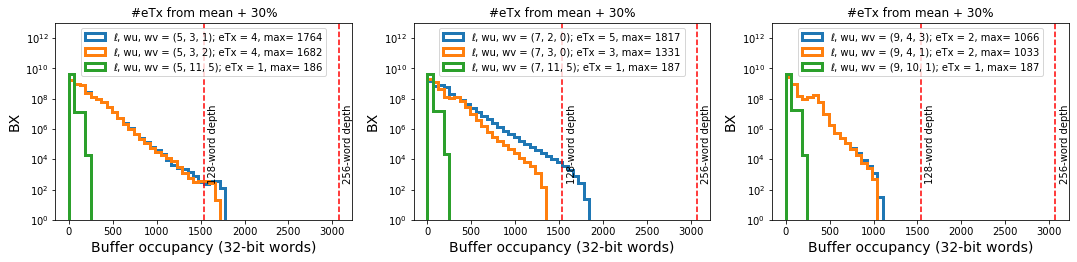

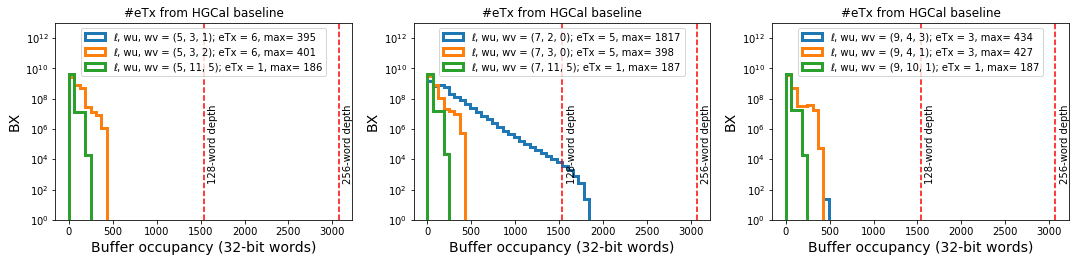

min_eTx


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


eTx_assigned
maxSize_assigned
overflows_assigned
eTx_Mean
maxSize_Mean
overflows_Mean
eTx_30percent
maxSize_30percent
overflows_30percent
eTx_30percent_actual
eTx_15percent
maxSize_15percent
overflows_15percent
eTx_15percent_actual


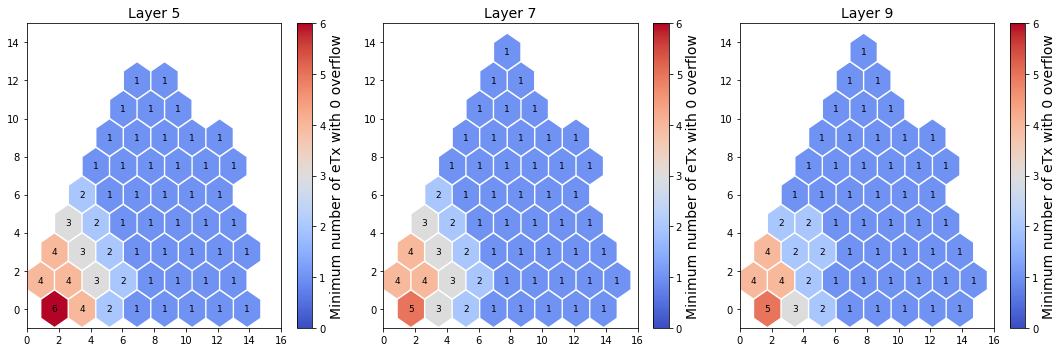

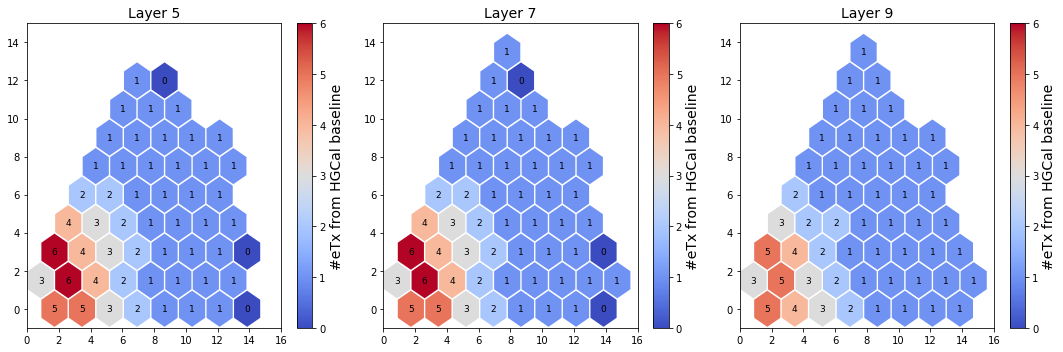

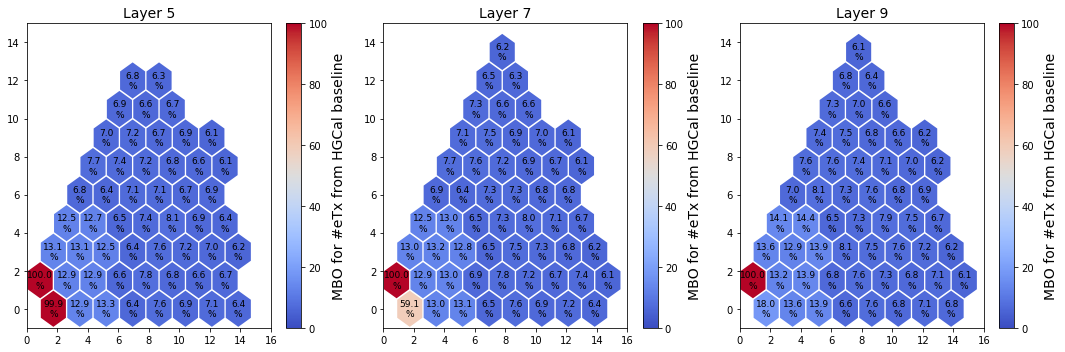

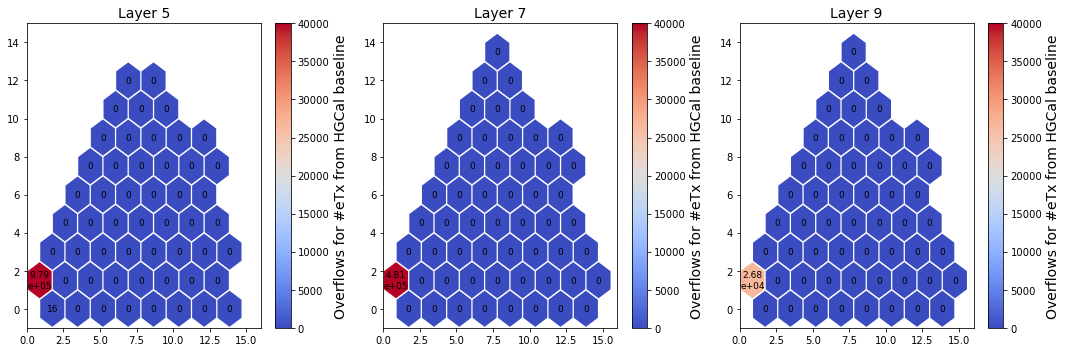

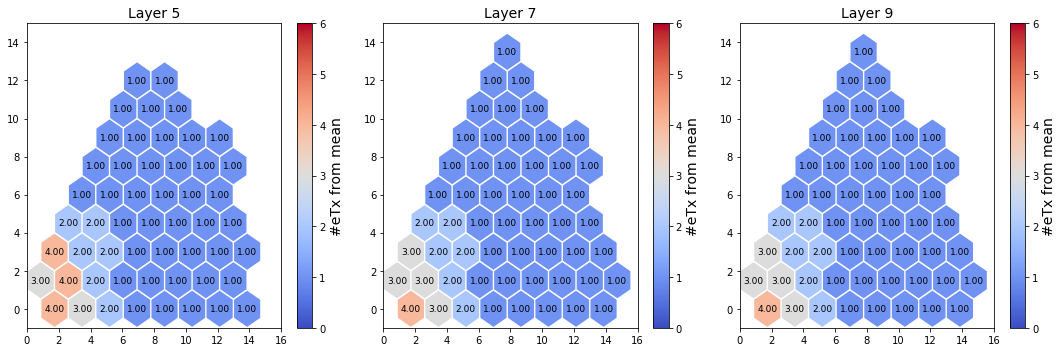

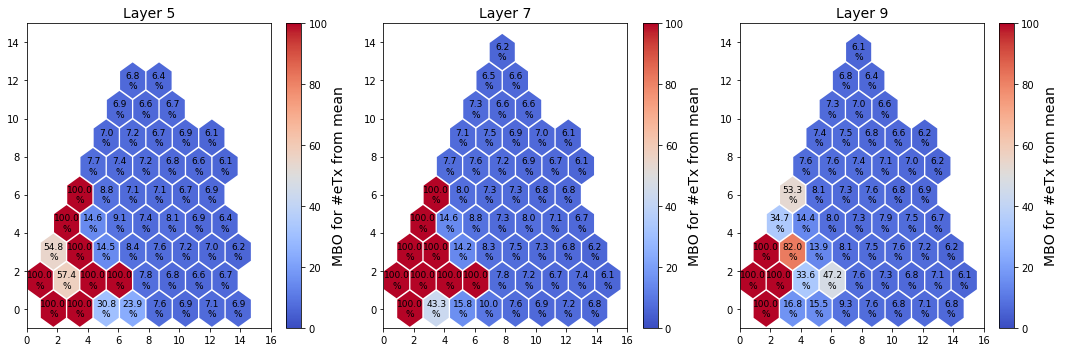

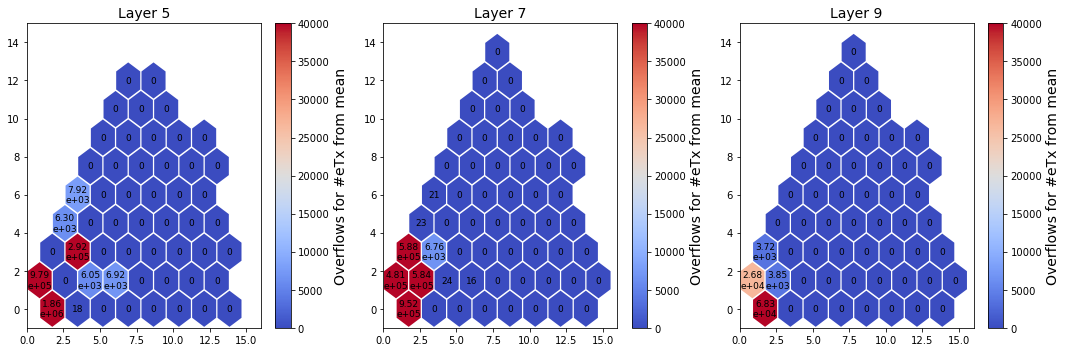

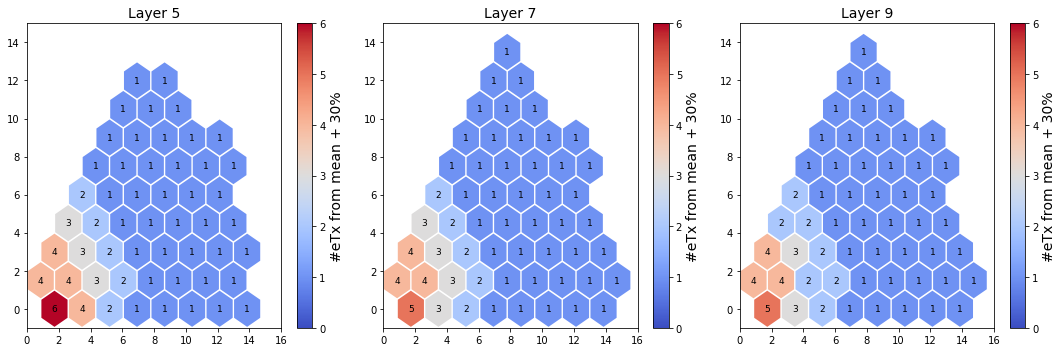

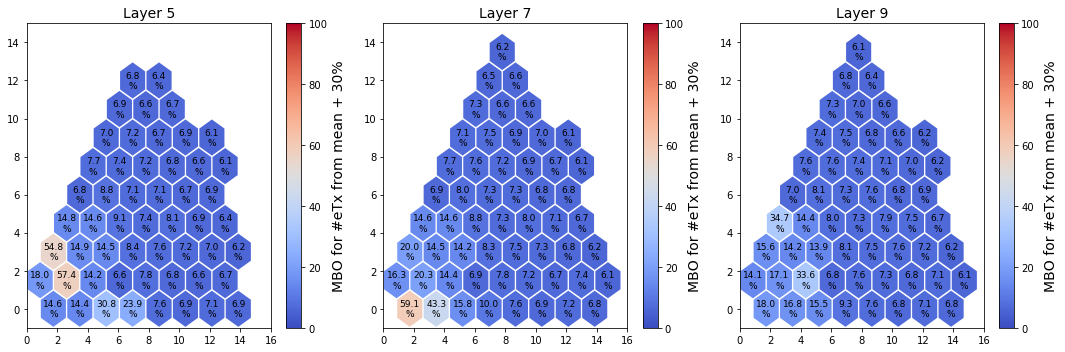

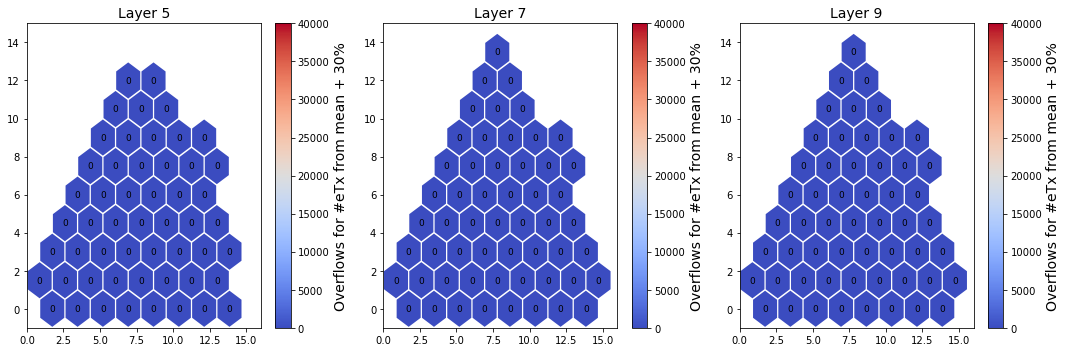

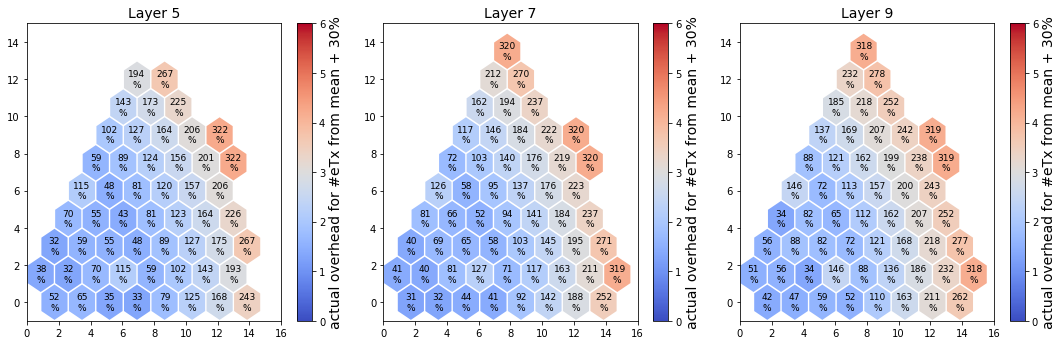

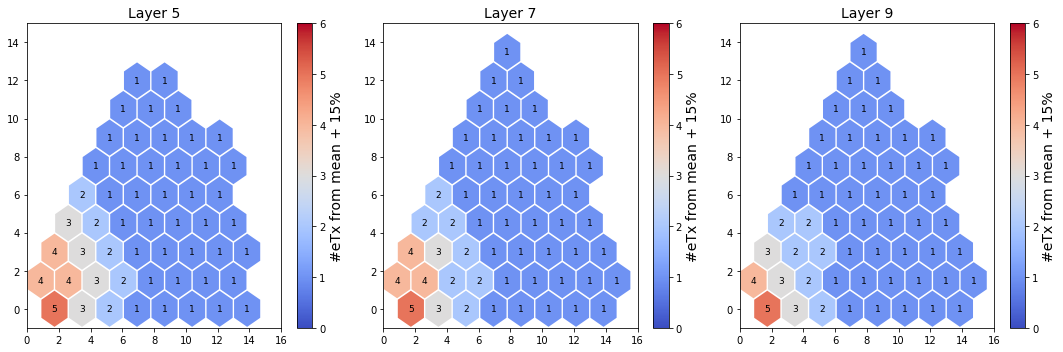

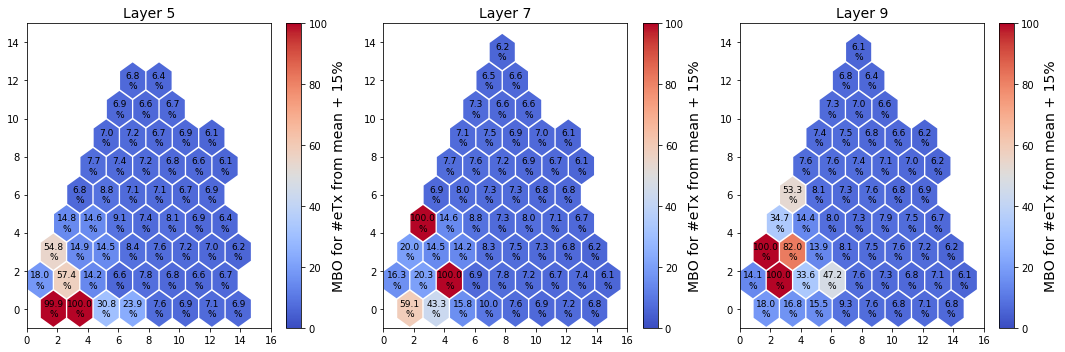

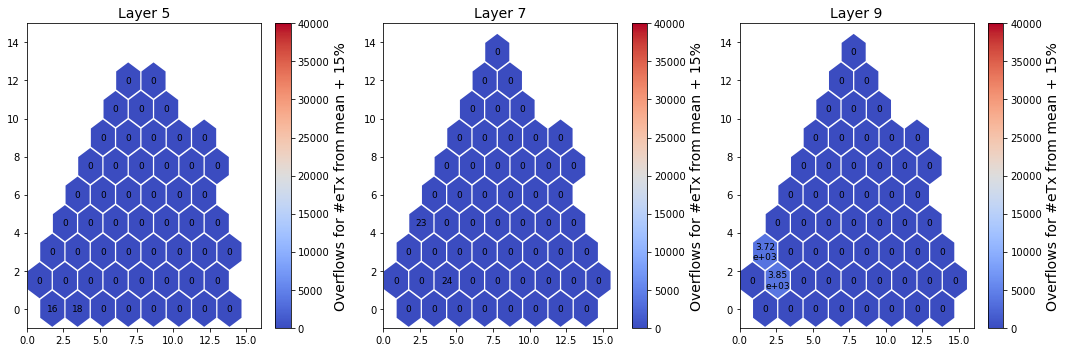

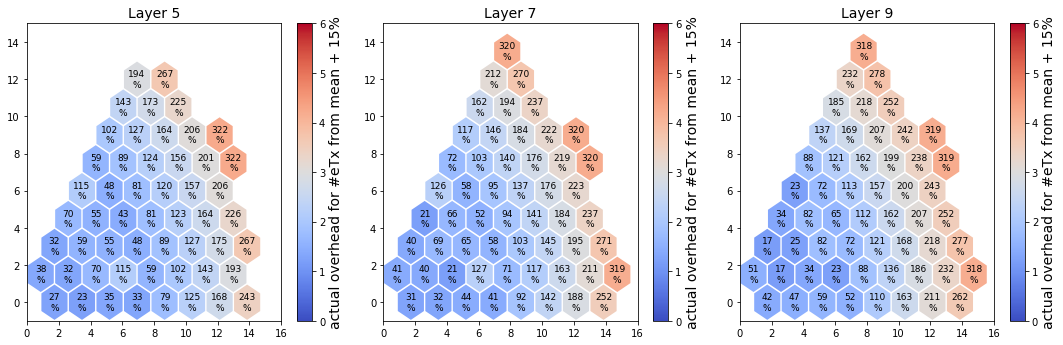

(5, 3, 1)
(5, 3, 2)
(5, 11, 5)
(7, 2, 0)
(7, 3, 0)
(7, 11, 5)
(9, 4, 3)
(9, 4, 1)
(9, 10, 1)


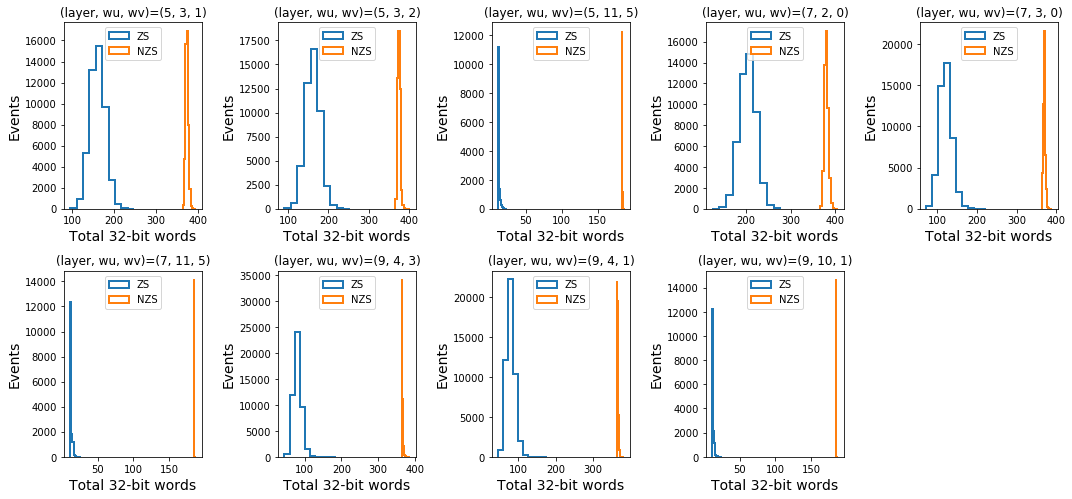

In [98]:
plotAll(fullData2, L1As2, buffHist2, OF2, MS2)